In [727]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE

In [728]:
housing_data = pd.read_csv('../../../datasets/surprise_housing_data.csv')
housing_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [729]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [730]:
##Checking and dropping duplicated records(if any)
housing_data = housing_data.drop_duplicates()

In [731]:
##Check null values if any(column wise: missing value percentage)
null_percentages = housing_data.isnull().mean() * 100
null_percentages

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64

In [732]:
# columns having more than 80% null values
null_percentages[null_percentages > 80]

Alley          93.767123
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64

In [733]:
columns_to_drop = null_percentages[null_percentages > 80].index.tolist()
columns_to_drop

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [734]:
housing_data = housing_data.drop(columns=columns_to_drop)
housing_data.shape

(1460, 77)

In [735]:
# drop 'Id' column as it is only index and we already have index in dataframe
housing_data = housing_data.drop(columns='Id')
housing_data.shape

(1460, 76)

In [736]:
# Categorizing categorical columns and numerical columns 
num_cols = []
cat_cols = []
def update_num_cat_cols(df):
    for col_name in df.columns:
        if df[col_name].dtype != 'object':
            num_cols.append(col_name)
        else:
            cat_cols.append(col_name)
update_num_cat_cols(housing_data)
print('num_cols size', len(num_cols))
print('cat_cols size', len(cat_cols))

num_cols size 37
cat_cols size 39


In [737]:
num_cols_null_percent = housing_data[num_cols].isnull().mean() * 100
null_num_cols = num_cols_null_percent[num_cols_null_percent > 0].index.tolist()
null_num_cols

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [738]:
print("Null value count:")
for col in null_num_cols:
    print(col, housing_data[col].isnull().sum())
print("\n")
print("Median:")
for col in null_num_cols:
    print(col, housing_data[col].median())
print("\n")
print("Null percentage:")
for col in null_num_cols:
    print(col, round(housing_data[col].isnull().mean()*100, 2))

Null value count:
LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


Median:
LotFrontage 69.0
MasVnrArea 0.0
GarageYrBlt 1980.0


Null percentage:
LotFrontage 17.74
MasVnrArea 0.55
GarageYrBlt 5.55


In [739]:
# filling null values of numeric columns with median
for col in null_num_cols:
    housing_data[col] = housing_data[col].fillna(housing_data[col].median())

In [740]:
# checking if any numeric column still having null values
housing_data[num_cols].columns[housing_data[num_cols].isnull().mean()*100 > 0]

Index([], dtype='object')

_Null values are removed from numeric columns_

In [741]:
cat_cols_null_percent = housing_data[cat_cols].isnull().mean() * 100
null_cat_cols = list(cat_cols_null_percent[cat_cols_null_percent > 0].index)
null_cat_cols

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

In [742]:
none_for_null_cat_cols = null_cat_cols
none_for_null_cat_cols.remove('Electrical')
mode_for_null_cat_cols = ['Electrical']
print(none_for_null_cat_cols)
print(mode_for_null_cat_cols)

['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
['Electrical']


In [743]:
housing_data[none_for_null_cat_cols] = housing_data[none_for_null_cat_cols].fillna('None')
for col in mode_for_null_cat_cols:
    housing_data[col] = housing_data[col].fillna(housing_data[col].mode()[0])

In [744]:
# check if any categorical column still having null values
housing_data[cat_cols].columns[housing_data[cat_cols].isnull().mean()*100 > 0]

Index([], dtype='object')

In [745]:
def get_columns_with_dominant_category(df, threshold=0.8):
    dominant_columns = []
    
    for col_name in df.columns:
        value_counts = df[col_name].value_counts(normalize=True)
        if value_counts.iloc[0] >= threshold:
            dominant_columns.append(col_name)
    
    return dominant_columns

dominant_cat_cols = get_columns_with_dominant_category(housing_data[cat_cols])
dominant_cat_cols

['Street',
 'LandContour',
 'Utilities',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'RoofMatl',
 'ExterCond',
 'BsmtCond',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [746]:
housing_data = housing_data.drop(columns=dominant_cat_cols)
housing_data.shape

(1460, 56)

In [747]:
# Updating categorical columns and numerical columns 
num_cols = []
cat_cols = []
update_num_cat_cols(housing_data)
print('num_cols size', len(num_cols))
print('cat_cols size', len(cat_cols))

num_cols size 37
cat_cols size 19


In [748]:
def plot_cat_variables(df, columns):
    for col_name in columns:
        counts = df[col_name].value_counts()
        
        # calculate the percentage of each value
        percentages = counts / len(df) * 100
        
        # create a bar plot of the counts
        plt.figure(figsize=(15, 4))
        plt.bar(counts.index, counts)
        
        # add a text label to each bar displaying the percentage
        for k, v in enumerate(counts):
            plt.text(k, v + 3, str(round(percentages.iloc[k], 2)) + '%', ha='center', rotation=45)
        
        # set the title and labels of the plot
        plt.title('Count vs '+col_name)
        plt.xticks(rotation=45)
        plt.margins(y=0.2)
        plt.xlabel(col_name)
        plt.ylabel('Count')
        plt.show()

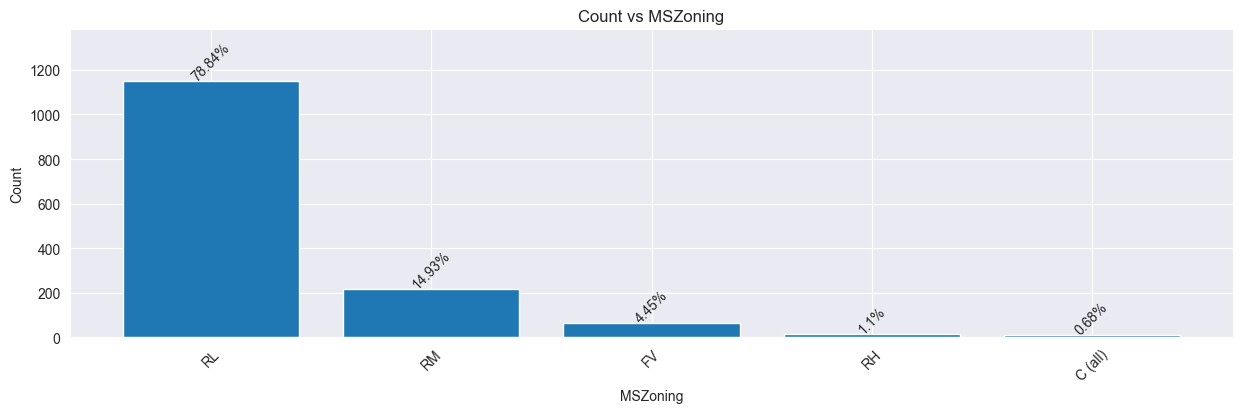

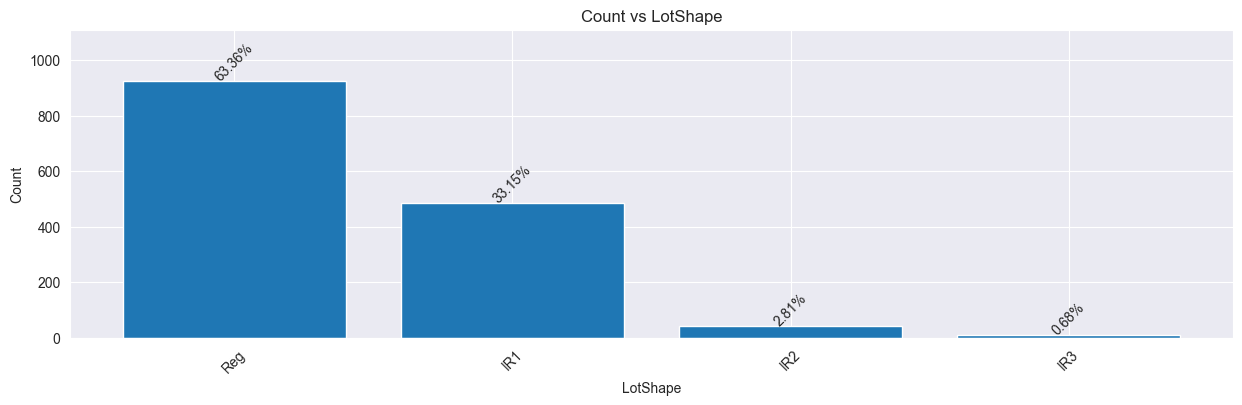

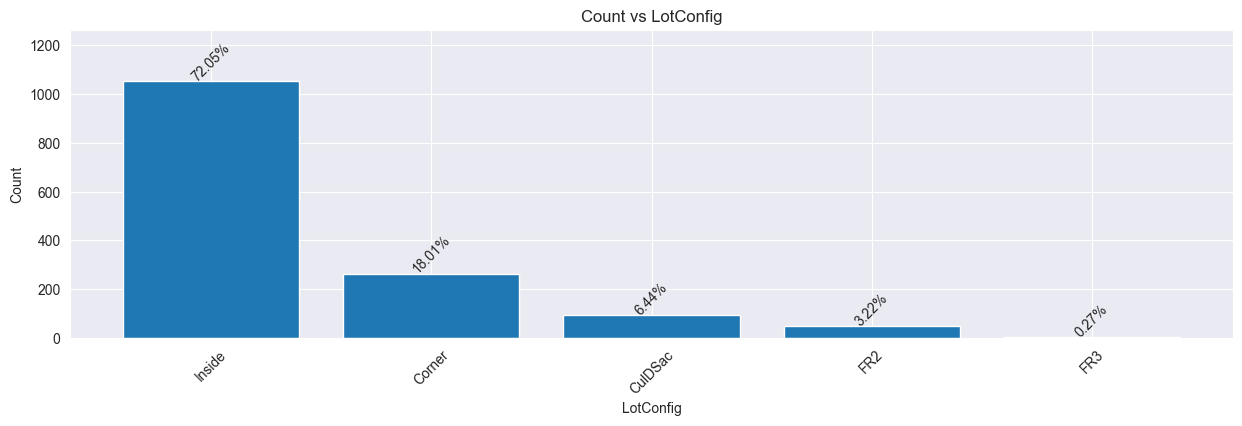

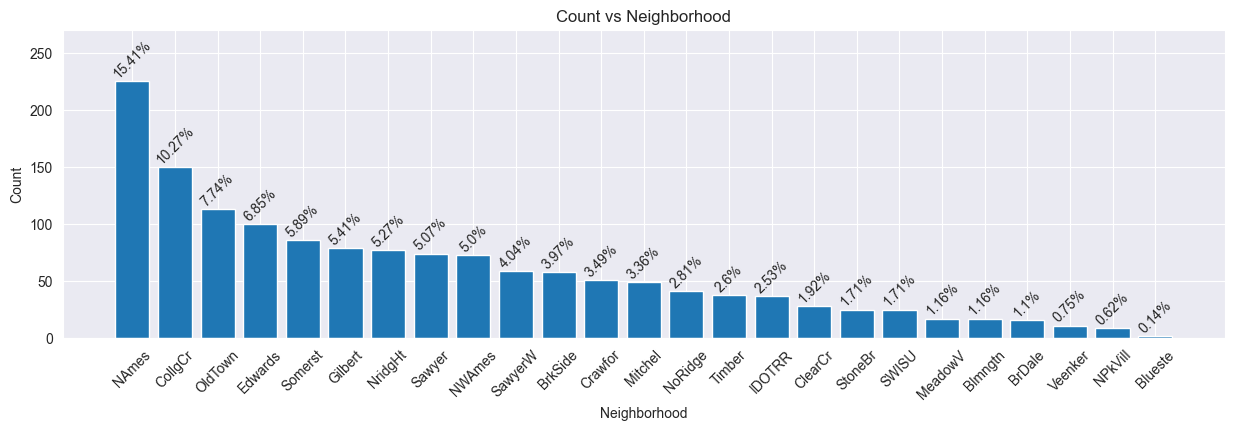

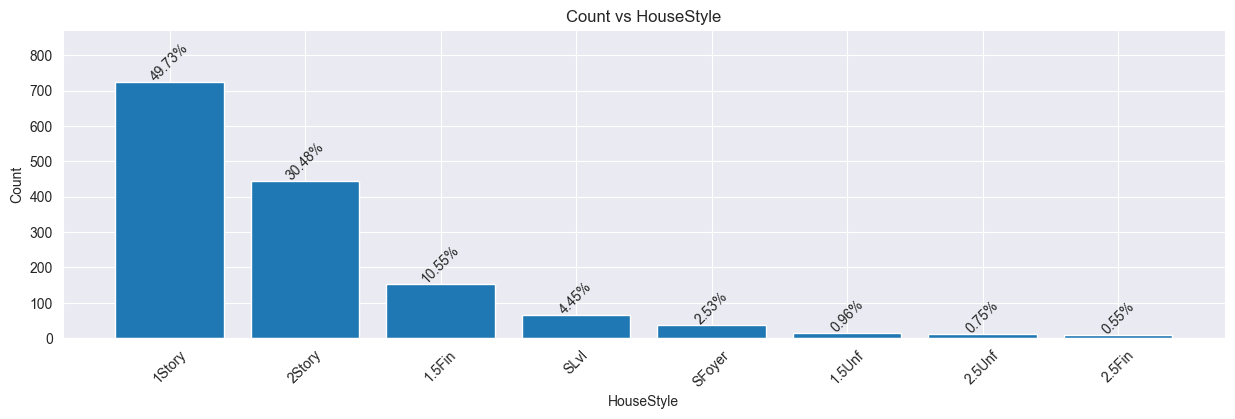

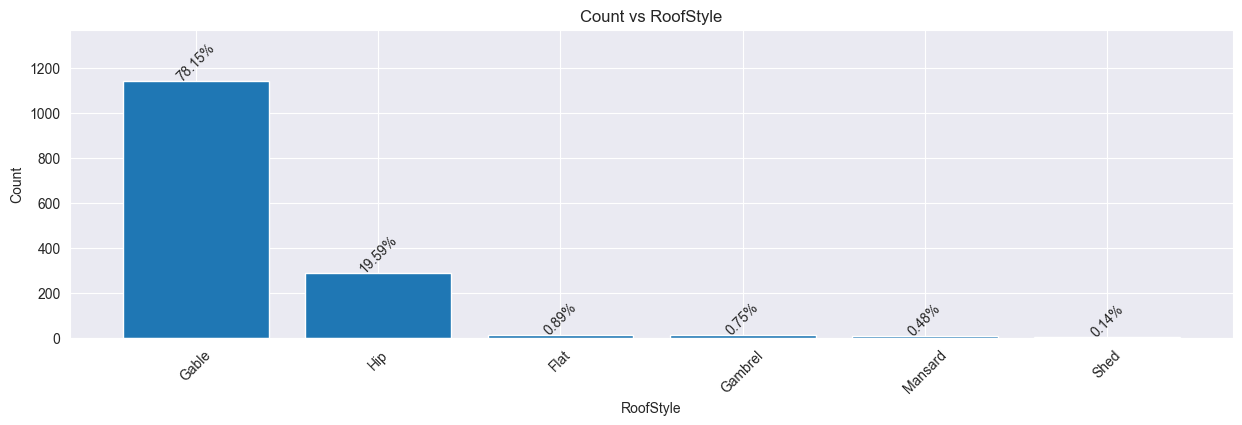

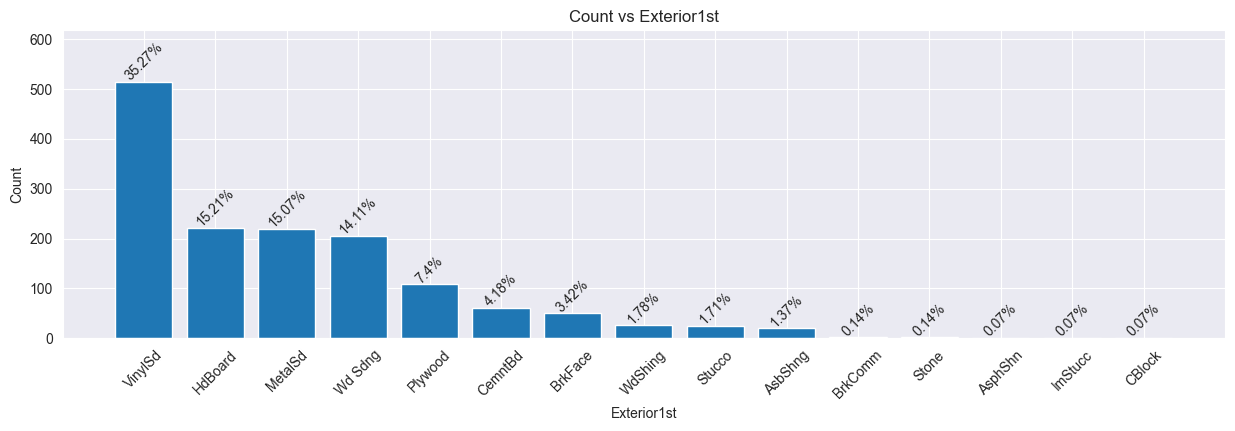

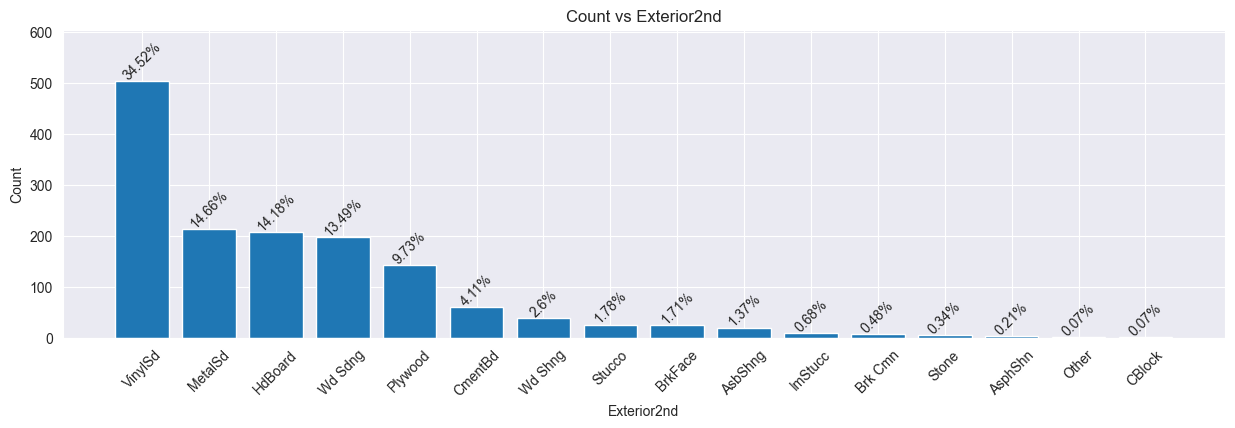

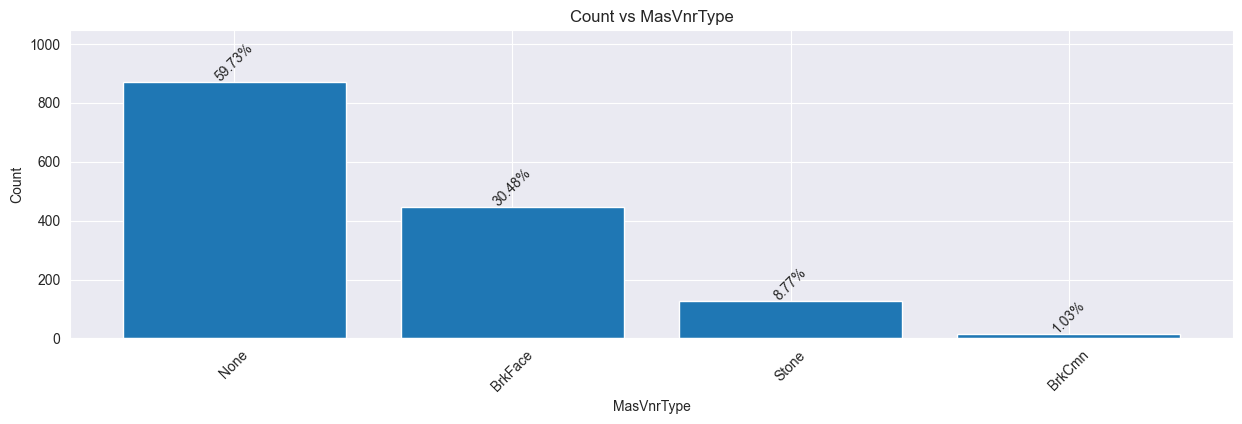

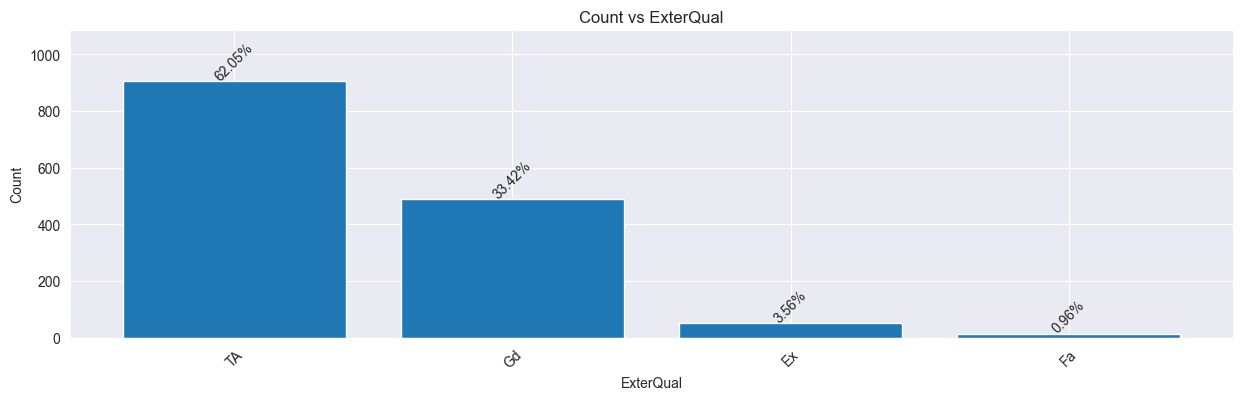

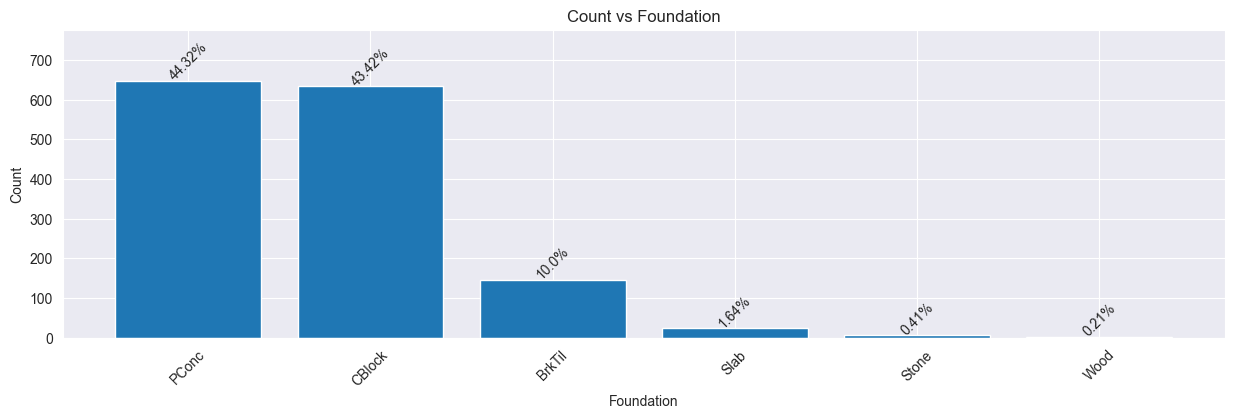

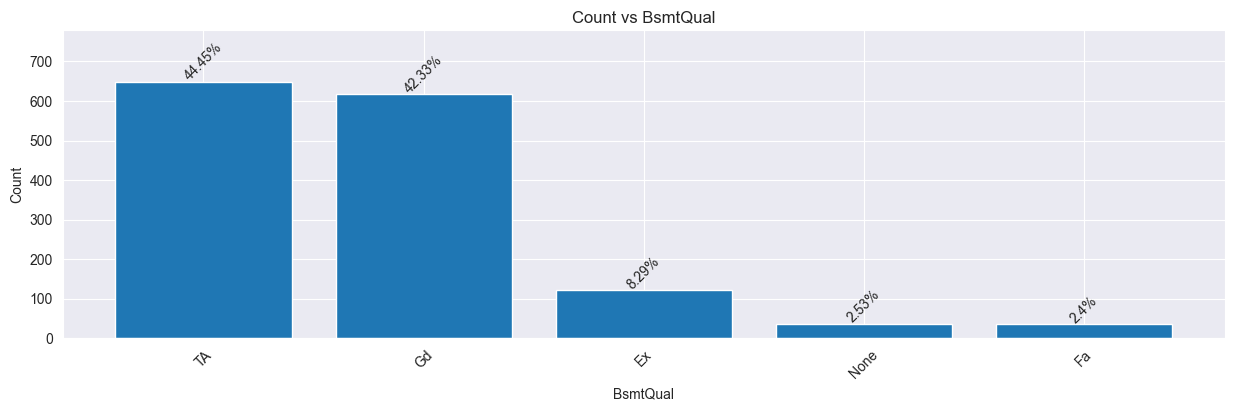

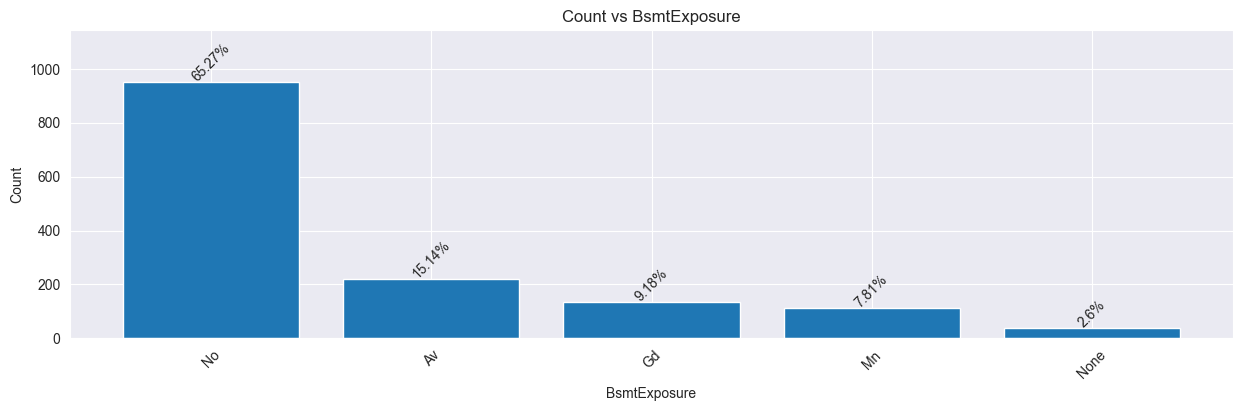

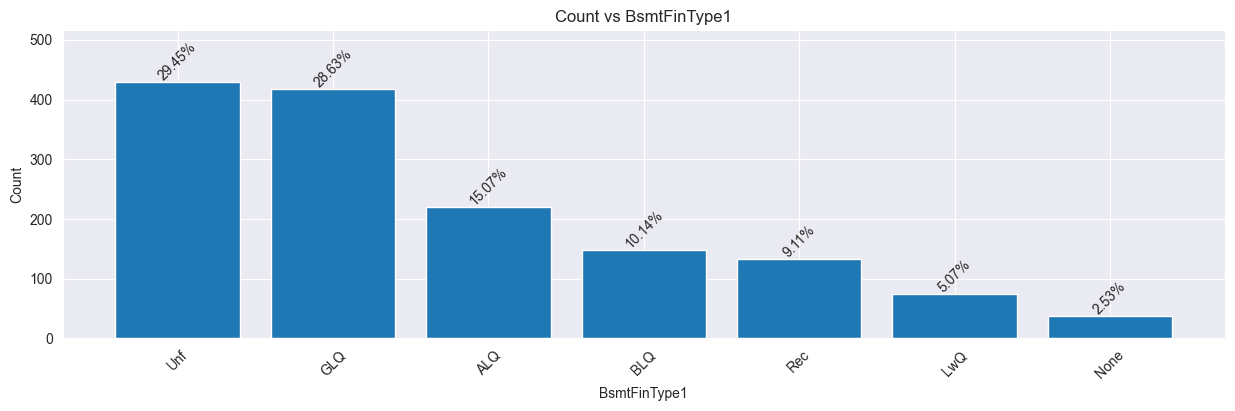

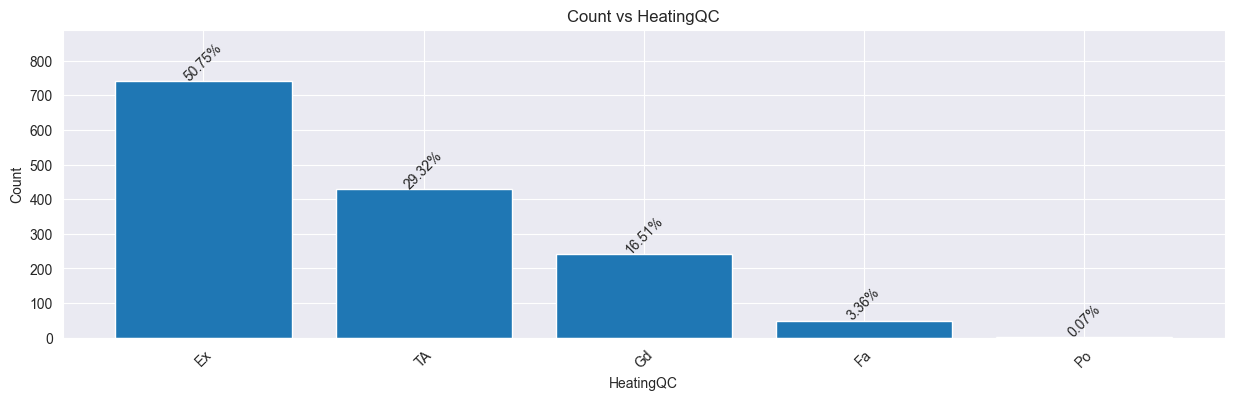

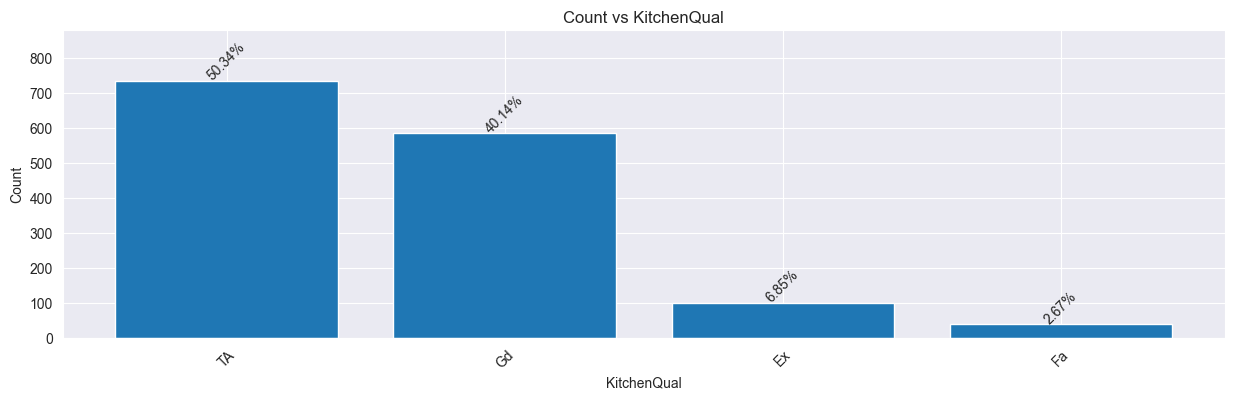

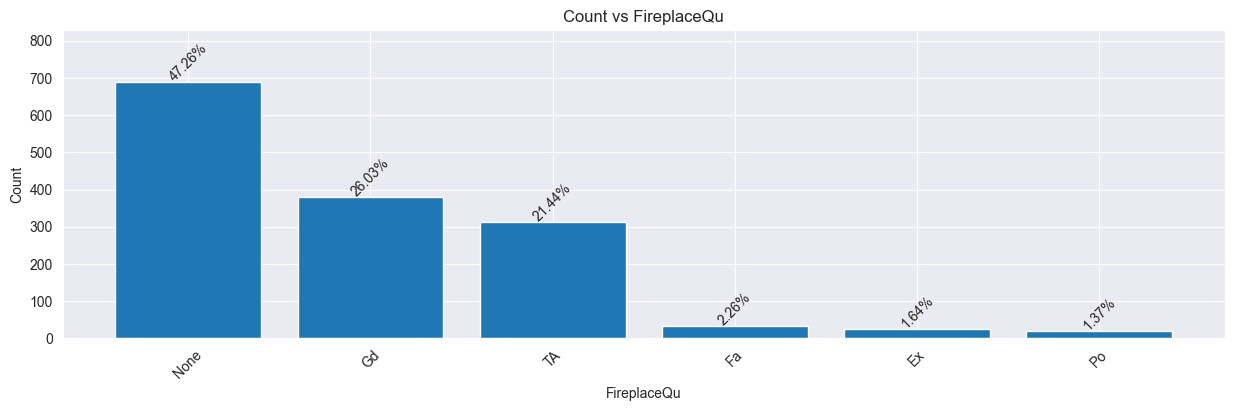

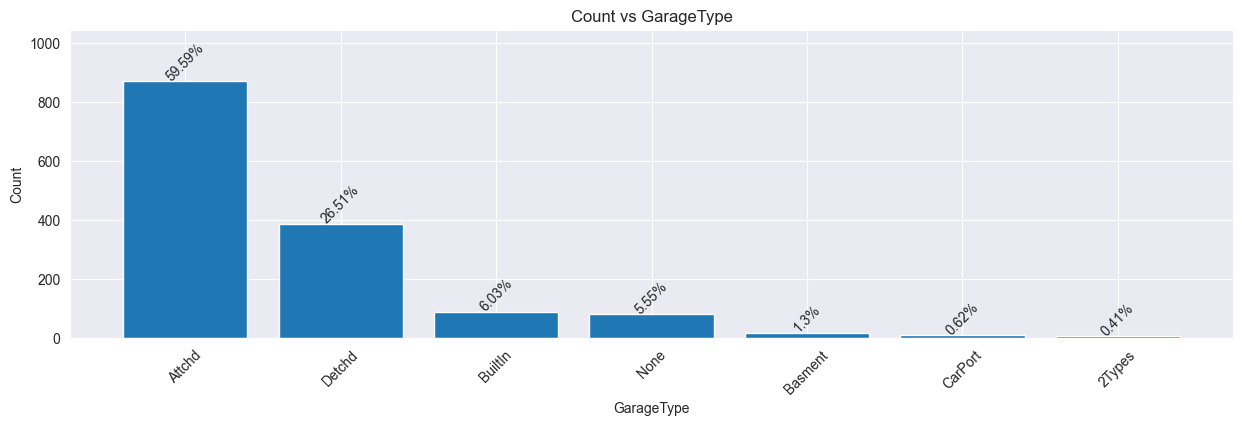

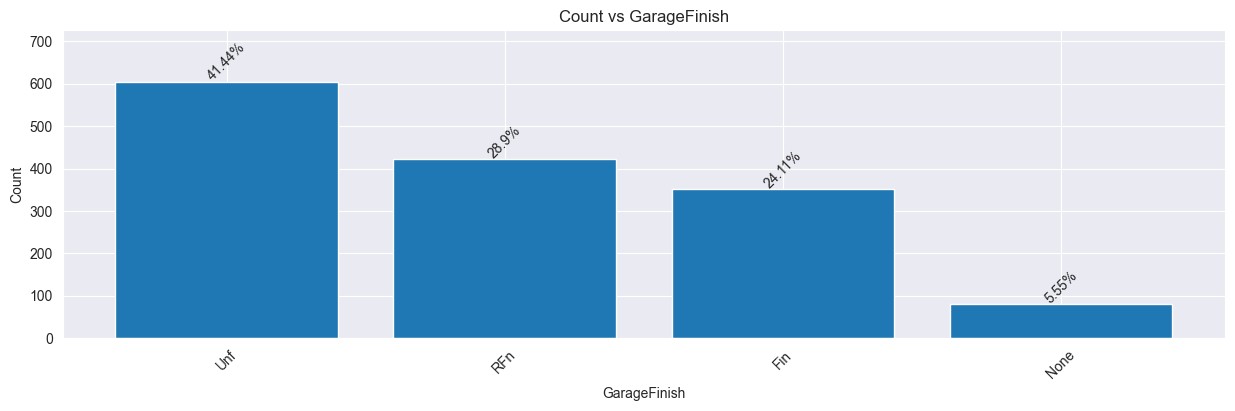

In [749]:
plot_cat_variables(housing_data, cat_cols)

__Observations:__
Most preferred choices:
1. (MSZoning) zone of the sale:`'RL'(Residential Low Density)` followed by `'RM'(Residential Medium Density)`.
2. LotShape: `Reg(Regular)` type
3. LotConfig: `Inside`(Inside lot)
4. No significant preference w.r.t following features:
    (i) FireplaceQu (Quality), MasVnrType: `'None'`
    (ii) KitchenQual (Quality), ExterQual (Quality of exterior material), BsmtQual (Height of basement):`'TA'(Typical/Average)`
5. RoofStyle: `'Gable'`
6. GarageType: `Attached`
7. GarageFinish: `Unfinished`
8. Foundation: `Poured Concrete`
9. (BsmtFinType1) Rating of Basement Fin. Area: `Good Living Quarters` and `Unfinished`
10. HeatingQC: `Excellent`
11. Neighborhood: `North Ames`, followed by `College Creek`
12. HouseStyle: `One story`, followed by `Two story`
13. Exterior1st (Exterior covering on the house) and Exterior2nd (if more than one material on exterior): `Vinyl Siding`, followed by `Metal Siding`
14. Basement Exposure: `No Exposure`

In [750]:
# Derived data
housing_data['IsRemodelled'] = housing_data.apply(lambda x : 0 if (x['YearBuilt'] == x['YearRemodAdd']) else 1, axis=1)
housing_data['IsRemodelled'].value_counts()

IsRemodelled
0    764
1    696
Name: count, dtype: int64

In [751]:
housing_data['PropAgeAtSale'] = housing_data.apply(lambda x : (x['YrSold'] - x['YearBuilt']), axis=1)
housing_data['PropAgeAtSale'].value_counts()

PropAgeAtSale
1      100
0       64
4       41
2       39
3       36
      ... 
115      1
122      1
128      1
114      1
125      1
Name: count, Length: 122, dtype: int64

In [752]:
housing_data = housing_data.drop(columns=['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'])
housing_data.shape

(1460, 54)

In [753]:
num_cols = []
cat_cols = []
update_num_cat_cols(housing_data)
print(len(num_cols))
print(len(cat_cols))

35
19


In [754]:
dominant_num_cols = get_columns_with_dominant_category(housing_data[num_cols])
dominant_num_cols

['BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [755]:
housing_data = housing_data.drop(columns=dominant_num_cols)
housing_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LotConfig', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'SalePrice', 'IsRemodelled',
       'PropAgeAtSale'],
      dtype='object')

In [756]:
# Dropping month of property sale as it is not important
housing_data = housing_data.drop(columns=['MoSold'])
housing_data.shape

(1460, 44)

In [757]:
num_cols = []
cat_cols = []
update_num_cat_cols(housing_data)
print(len(num_cols))
print(len(cat_cols))

25
19


In [758]:
##Check outliers
housing_data.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.98,0.99,1])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,PropAgeAtSale
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,103.117123,443.639726,567.240411,1057.429452,1162.626712,...,2.866438,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,180921.195890,0.476712,36.547945
std,42.300571,22.027677,9981.264932,1.382997,1.112799,180.731373,456.098091,441.866955,438.705324,386.587738,...,0.815778,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,79442.502883,0.499629,30.250152
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,0.000000
10%,20.000000,49.000000,5000.000000,5.000000,5.000000,0.000000,0.000000,74.900000,636.900000,756.900000,...,2.000000,5.000000,0.000000,1.000000,240.000000,0.000000,0.000000,106475.000000,0.000000,1.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,2.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,129975.000000,0.000000,8.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,...,3.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000,0.000000,35.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,808.000000,1298.250000,1391.250000,...,3.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000,1.000000,54.000000
95%,160.000000,104.000000,17401.150000,8.000000,8.000000,456.000000,1274.000000,1468.000000,1753.000000,1831.250000,...,4.000000,10.000000,2.000000,3.000000,850.100000,335.000000,175.050000,326100.000000,1.000000,91.000000
98%,188.200000,120.820000,25251.620000,9.000000,8.000000,650.820000,1442.640000,1678.200000,2001.640000,2072.280000,...,4.000000,10.820000,2.000000,3.000000,907.460000,430.100000,240.820000,394931.060000,1.000000,100.000000


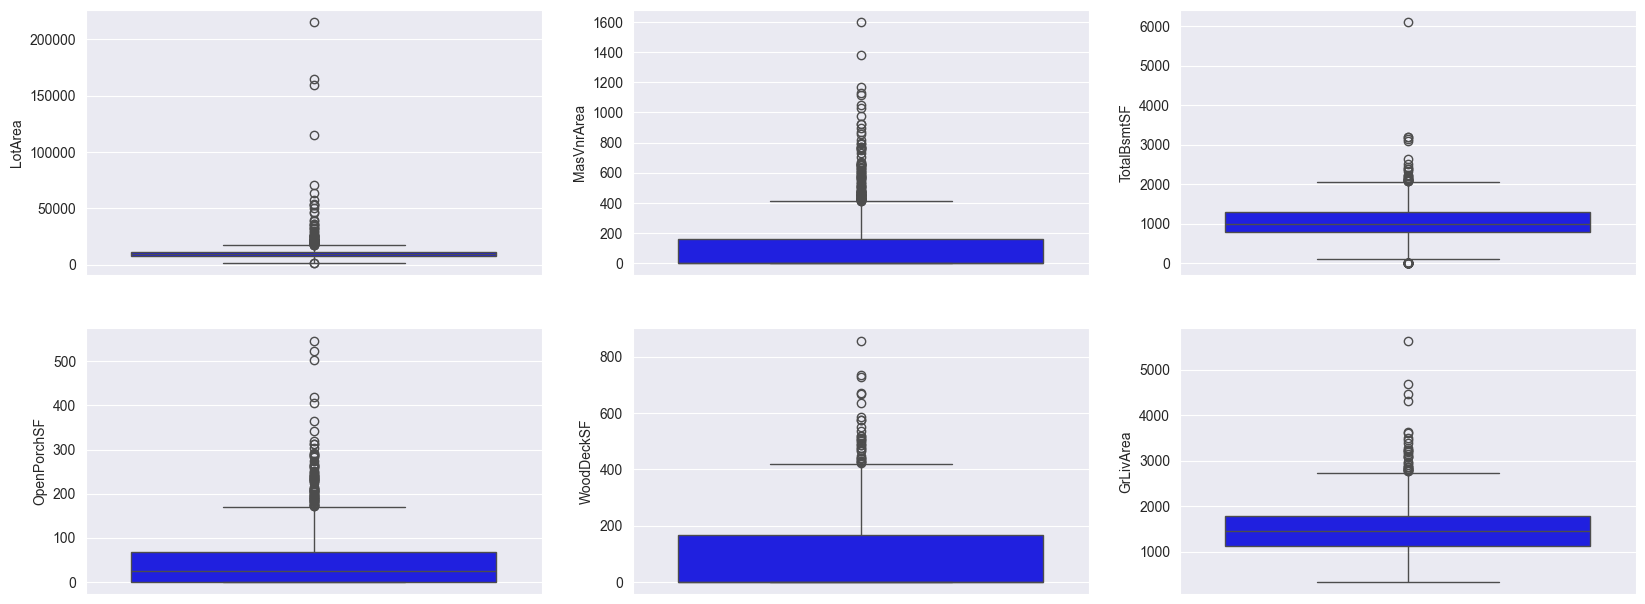

In [759]:
# Check the outliers in all the numeric columns (boxplot)

plt.figure(figsize=(20, 20))
plt.subplot(5,3,1)
sns.boxplot(y = 'LotArea', color='b', data = housing_data)
plt.subplot(5,3,2)
sns.boxplot(y = 'MasVnrArea', color='b', data = housing_data)
plt.subplot(5,3,3)
sns.boxplot(y = 'TotalBsmtSF', color='b', data = housing_data)
plt.subplot(5,3,4)
sns.boxplot(y = 'OpenPorchSF', color='b', data = housing_data)
plt.subplot(5,3,5)
sns.boxplot(y = 'WoodDeckSF', color='b', data = housing_data)
plt.subplot(5,3,6)
sns.boxplot(y = 'GrLivArea', color='b', data = housing_data)


plt.show()

In [760]:
# Calculate the 99th percentile of each numeric column
q99 = housing_data[num_cols].quantile(0.99)
# Create a boolean mask to identify rows where all numeric columns are less than or equal to their respective 99th percentile values
mask = housing_data[num_cols].le(q99).all(axis=1)
# Filter the DataFrame using the boolean mask
housing_data_filtered = housing_data[mask]
housing_data_filtered

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,PropAgeAtSale
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,...,None,Attchd,RFn,2,548,0,61,208500,0,5
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,...,TA,Attchd,RFn,2,460,298,0,181500,0,31
2,60,RL,68.0,11250,IR1,Inside,CollgCr,2Story,7,5,...,TA,Attchd,RFn,2,608,0,42,223500,1,7
3,70,RL,60.0,9550,IR1,Corner,Crawfor,2Story,7,5,...,Gd,Detchd,Unf,3,642,0,35,140000,1,91
4,60,RL,84.0,14260,IR1,FR2,NoRidge,2Story,8,5,...,TA,Attchd,RFn,3,836,192,84,250000,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,20,FV,62.0,7500,Reg,Inside,Somerst,1Story,7,5,...,None,Attchd,RFn,2,400,0,113,185000,1,5
1455,60,RL,62.0,7917,Reg,Inside,Gilbert,2Story,6,5,...,TA,Attchd,RFn,2,460,0,40,175000,1,8
1456,20,RL,85.0,13175,Reg,Inside,NWAmes,1Story,6,6,...,TA,Attchd,Unf,2,500,349,0,210000,1,32
1457,70,RL,66.0,9042,Reg,Inside,Crawfor,2Story,7,9,...,Gd,Attchd,RFn,1,252,0,60,266500,1,69


In [761]:
len(housing_data_filtered)/len(housing_data)

0.8924657534246575

In [762]:
housing_data_filtered.describe(percentiles=[0.1,0.25,0.5,0.75,0.95,0.98,0.99,1])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice,IsRemodelled,PropAgeAtSale
count,1303.000000,1303.000000,1303.000000,1303.00000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,...,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000
mean,56.373753,68.004605,9445.900998,5.99693,5.588642,86.436685,417.400614,547.961627,1009.854183,1114.964697,...,2.815042,6.305449,0.566385,1.716807,457.190330,85.459708,41.335380,170960.057559,0.468150,36.329240
std,42.481052,18.158290,3918.278519,1.29218,1.110456,140.602447,402.300855,417.216228,368.989735,327.870657,...,0.741788,1.426766,0.609706,0.709006,196.588009,110.752792,55.521591,63307.247672,0.499176,29.091277
min,20.000000,21.000000,1300.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35311.000000,0.000000,0.000000
10%,20.000000,48.000000,4920.600000,5.00000,5.000000,0.000000,0.000000,70.000000,626.800000,751.200000,...,2.000000,5.000000,0.000000,1.000000,240.000000,0.000000,0.000000,105000.000000,0.000000,1.000000
25%,20.000000,60.000000,7389.000000,5.00000,5.000000,0.000000,0.000000,217.500000,788.000000,864.000000,...,2.000000,5.000000,0.000000,1.000000,312.000000,0.000000,0.000000,128350.000000,0.000000,8.000000
50%,50.000000,69.000000,9200.000000,6.00000,5.000000,0.000000,375.000000,465.000000,969.000000,1056.000000,...,3.000000,6.000000,1.000000,2.000000,467.000000,0.000000,22.000000,158000.000000,0.000000,36.000000
75%,70.000000,77.000000,11200.000000,7.00000,6.000000,145.000000,688.000000,792.500000,1238.500000,1330.000000,...,3.000000,7.000000,1.000000,2.000000,572.000000,164.000000,63.000000,202500.000000,1.000000,55.000000
95%,160.000000,99.900000,15601.100000,8.00000,8.000000,386.400000,1185.400000,1389.000000,1651.800000,1703.700000,...,4.000000,9.000000,2.000000,3.000000,826.000000,304.900000,158.000000,296849.300000,1.000000,89.000000
98%,180.000000,110.000000,19374.720000,9.00000,8.000000,509.240000,1335.920000,1584.000000,1765.480000,1837.920000,...,4.000000,10.000000,2.000000,3.000000,877.840000,370.000000,207.960000,335000.000000,1.000000,96.960000


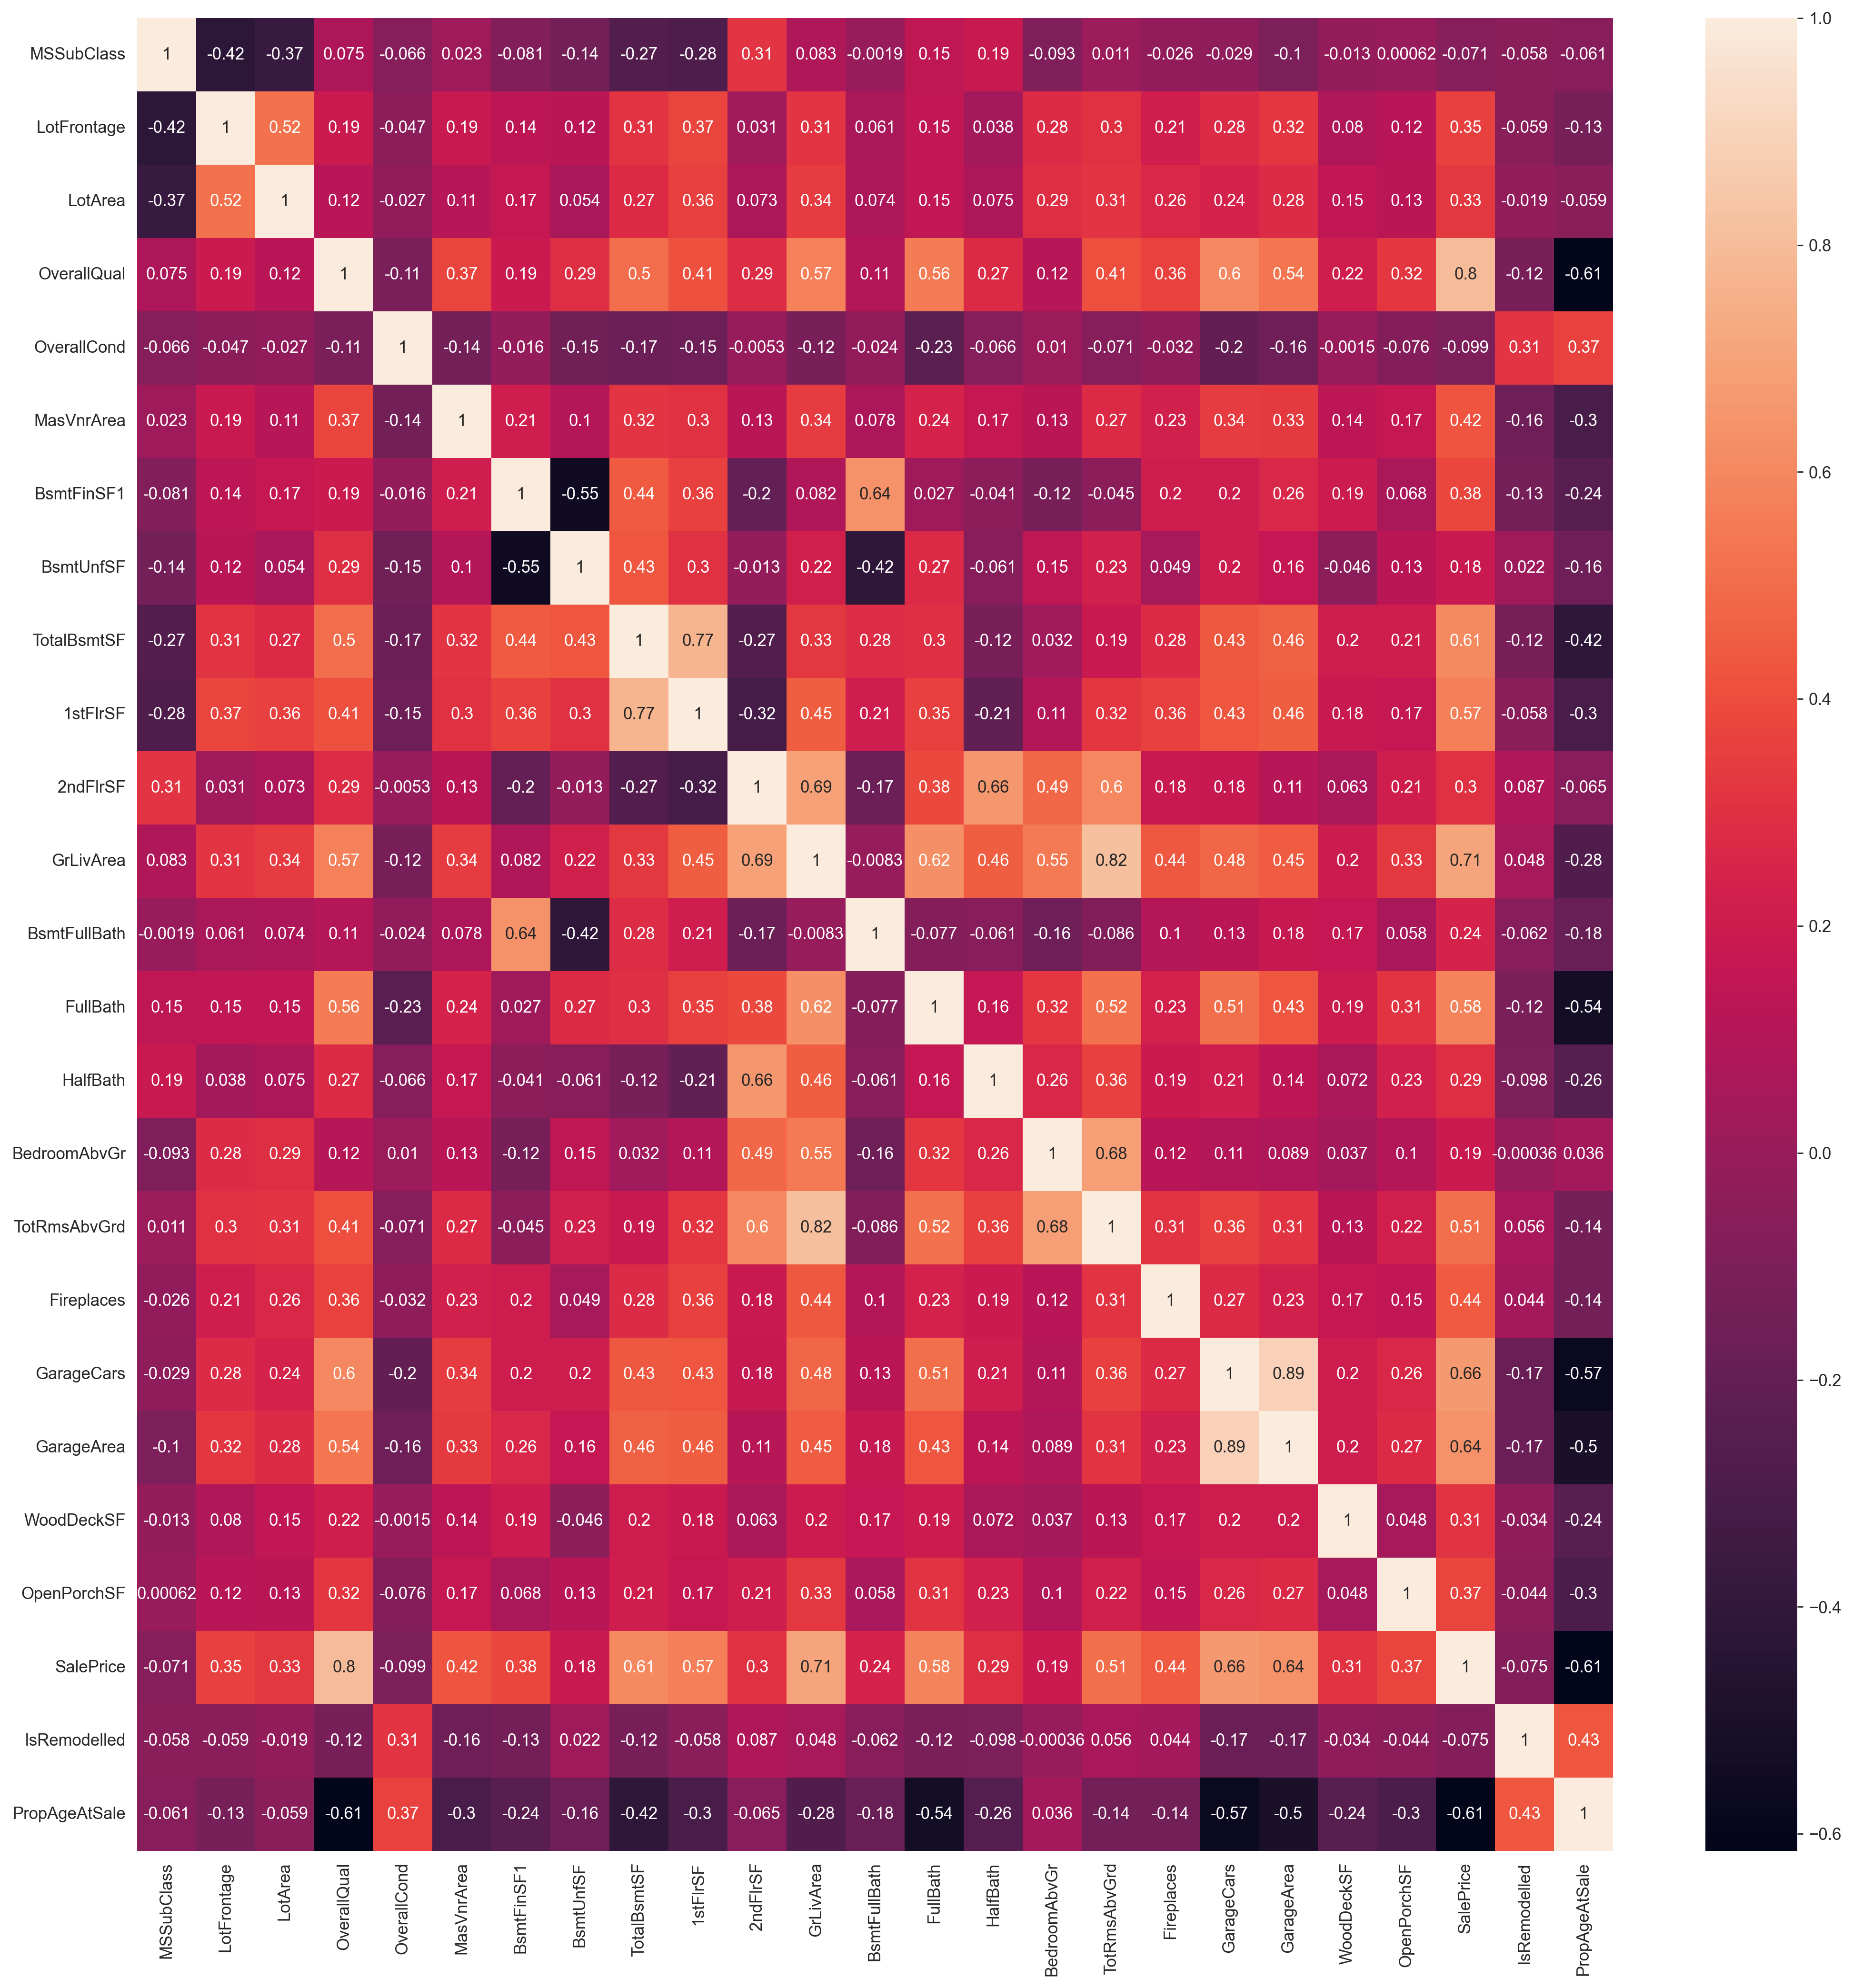

In [763]:
plt.figure(figsize=(20, 20), dpi=250)
sns.heatmap(housing_data_filtered[num_cols].corr(), annot=True)
plt.show()

__Observations:__
- The predictors `'GrLivArea'` and `'TotRmsAbvGrd'` shows (0.82) strong positive correlation. Hence, dropping `'TotRmsAbvGrd'`.
- The predictors `'GarageCars'` and `'GarageArea'` shows (0.89) strong positive correlation. Hence, dropping `'GarageArea'`.
- The predictors `'GrLivArea'` and `'2ndFlrSF'` shows (0.69) strong positive correlation. Hence, dropping `'2ndFlrSF'`.
- The predictors `'TotalBsmtSF'` and `'1stFlrSF'` shows (0.77) strong positive correlation. Hence, dropping `'1stFlrSF'`.

In [764]:
columns_to_drop = ['TotRmsAbvGrd', 'GarageArea', '2ndFlrSF', '1stFlrSF']
housing_data_filtered = housing_data_filtered.drop(columns=columns_to_drop)
housing_data_filtered.shape

(1303, 40)

In [765]:
num_cols = []
cat_cols = []
update_num_cat_cols(housing_data_filtered)
print(len(num_cols))
print(len(cat_cols))

21
19


In [766]:
# Mapping 'MSSubClass' values to description
housing_data_filtered['MSSubClass'] = housing_data_filtered['MSSubClass'].map({
    20: 'ONE_STORY_LATEST',
    30:	'ONE_STORY_OLDER',
    40: 'ONE_STORY_FINISHED_ATTIC',
    45:	'ONE_HALF_STORY_UNFINISHED',
    50:	'ONE_HALF_STORY_FINISHED',
    60:	'TW0_STORY_NEWER',
    70:	'TWO_STORY_OLDER',
    75:	'TWO_HALF_STORY',
    80:	'SPLIT_OR_MULTI_LEVEL',
    85:	'SPLIT_FOYER',
    90:	'DUPLEX',
    120: 'ONE_STORY_PUD',
    150: 'ONE_HALF_STORY_PUD',
    160: 'TWO_STORY_PUD',
    180: 'PUD_MULTILEVEL',
    190: 'TWO_FAMILY_CONVERSION'
})

In [767]:
# Splitting the numerical variables to ordinal and nominal
# For ordinals, we can do LabelEncoding
# For nominal, we can use dummies
ordinals = ['LotShape', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish']
nominals = ['MSSubClass','MSZoning', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType',  'LotConfig' ,'HouseStyle', 'MasVnrType']

In [768]:
encoder = LabelEncoder()
for col in housing_data_filtered[ordinals].columns:
    housing_data_filtered[col+'_encoded'] = encoder.fit_transform(housing_data_filtered[col])
housing_data_filtered = housing_data_filtered.drop(columns=ordinals)
housing_data_filtered.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,RoofStyle,...,PropAgeAtSale,LotShape_encoded,ExterQual_encoded,BsmtQual_encoded,BsmtExposure_encoded,BsmtFinType1_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageFinish_encoded
0,TW0_STORY_NEWER,RL,65.0,8450,Inside,CollgCr,2Story,7,5,Gable,...,5,3,2,2,3,2,0,2,3,2
1,ONE_STORY_LATEST,RL,80.0,9600,FR2,Veenker,1Story,6,8,Gable,...,31,3,3,2,1,0,0,3,5,2
2,TW0_STORY_NEWER,RL,68.0,11250,Inside,CollgCr,2Story,7,5,Gable,...,7,0,2,2,2,2,0,2,5,2
3,TWO_STORY_OLDER,RL,60.0,9550,Corner,Crawfor,2Story,7,5,Gable,...,91,0,3,4,3,0,2,2,2,3
4,TW0_STORY_NEWER,RL,84.0,14260,FR2,NoRidge,2Story,8,5,Gable,...,8,0,2,2,0,2,0,2,5,2


In [769]:
# convert into dummies
nominal_dummies = pd.get_dummies(housing_data_filtered[nominals], drop_first=True, dtype=int)
nominal_dummies.head()

,MSSubClass_ONE_HALF_STORY_FINISHED,MSSubClass_ONE_HALF_STORY_UNFINISHED,MSSubClass_ONE_STORY_FINISHED_ATTIC,MSSubClass_ONE_STORY_LATEST,MSSubClass_ONE_STORY_OLDER,MSSubClass_ONE_STORY_PUD,MSSubClass_PUD_MULTILEVEL,MSSubClass_SPLIT_FOYER,MSSubClass_SPLIT_OR_MULTI_LEVEL,MSSubClass_TW0_STORY_NEWER,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [770]:
# concat dummy variables with X
housing_data_filtered = pd.concat([housing_data_filtered, nominal_dummies], axis=1)
housing_data_filtered.shape

(1303, 141)

In [771]:
# drop categorical variables 
housing_data_filtered = housing_data_filtered.drop(columns=nominals)
housing_data_filtered.shape

(1303, 130)

In [772]:
##Rechecking and eliminating those predictor variables that have a correlation of (threshold:-0.7 to 0.7) with other predictors.

df_corr = housing_data_filtered.drop(['SalePrice'],axis =1)
my_corr_matrix = df_corr.corr().abs()
my_corr_matrix

upper_triangle = my_corr_matrix.where(np.triu(np.ones(my_corr_matrix.shape), k=1).astype(bool))
columns_to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.70)]  #Reduces multicollinearity (if any)
columns_to_drop  #columns to drop from df. Independent predictors highly correlated to each other

['MSZoning_RM',
 'Neighborhood_Somerst',
 'RoofStyle_Hip',
 'Exterior2nd_AsphShn',
 'Exterior2nd_CBlock',
 'Exterior2nd_CmentBd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Foundation_PConc',
 'GarageType_Detchd',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'MasVnrType_None']

In [773]:
housing_data_filtered = housing_data_filtered.drop(columns=columns_to_drop)
housing_data_filtered.shape

(1303, 110)

In [774]:
housing_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1458
Columns: 110 entries, LotFrontage to MasVnrType_Stone
dtypes: float64(2), int64(108)
memory usage: 1.1 MB


In [775]:
housing_data_encoded = housing_data_filtered.copy()

In [776]:
##Creating a function to find binary value columns from the 'df' dataframe (if any)
def get_binary_cols(df):
    bin_cols = (df.nunique()==2)
    list_bin_cols = list(bin_cols[bin_cols.values==True].index)
    return list_bin_cols

In [777]:
binary_cols = get_binary_cols(housing_data_filtered)
print(binary_cols)

['HalfBath', 'IsRemodelled', 'MSSubClass_ONE_HALF_STORY_FINISHED', 'MSSubClass_ONE_HALF_STORY_UNFINISHED', 'MSSubClass_ONE_STORY_FINISHED_ATTIC', 'MSSubClass_ONE_STORY_LATEST', 'MSSubClass_ONE_STORY_OLDER', 'MSSubClass_ONE_STORY_PUD', 'MSSubClass_PUD_MULTILEVEL', 'MSSubClass_SPLIT_FOYER', 'MSSubClass_SPLIT_OR_MULTI_LEVEL', 'MSSubClass_TW0_STORY_NEWER', 'MSSubClass_TWO_FAMILY_CONVERSION', 'MSSubClass_TWO_HALF_STORY', 'MSSubClass_TWO_STORY_OLDER', 'MSSubClass_TWO_STORY_PUD', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neig

### Train and Test split

In [778]:
df_train, df_test = train_test_split(housing_data_filtered, train_size=0.7, random_state=100)

In [779]:
# Preserving Dataframe with binary columns so that we concat them later to preserve the scale
df_binary_train = df_train.loc[:, binary_cols]
df_binary_test = df_test.loc[:, binary_cols]

In [780]:
# Dropping binary dummy variables before scaling
df_train = df_train.drop(columns=binary_cols)
df_test = df_test.drop(columns=binary_cols)

In [781]:
df_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,...,PropAgeAtSale,LotShape_encoded,ExterQual_encoded,BsmtQual_encoded,BsmtExposure_encoded,BsmtFinType1_encoded,HeatingQC_encoded,KitchenQual_encoded,FireplaceQu_encoded,GarageFinish_encoded
557,60.0,11040,4,6,0.0,637,0,637,1336,0,...,86,3,3,4,3,5,2,3,3,3
554,85.0,10625,7,5,292.0,866,132,998,2046,1,...,5,3,2,2,3,2,0,2,2,2
1115,93.0,12085,8,5,328.0,1004,730,1734,1734,1,...,0,3,2,0,3,2,0,0,2,2
283,74.0,9612,8,5,72.0,0,1468,1468,1468,0,...,1,3,2,2,3,6,0,2,2,0
870,60.0,6600,5,5,0.0,0,894,894,894,0,...,47,3,3,4,3,6,2,3,3,3


In [782]:
all_cols = df_train.columns
scaler = StandardScaler()

#scaler fit_transform on train data
df_train[all_cols] = scaler.fit_transform(df_train[all_cols])
#concat dummies:Train set
df_train = pd.concat([df_train, df_binary_train], axis=1)

#scaler transform on test data
df_test[all_cols] = scaler.transform(df_test[all_cols])
#concat dummies: Test set
df_test = pd.concat([df_test, df_binary_test], axis=1)

In [783]:
df_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,...,GarageType_CarPort,GarageType_None,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,HouseStyle_2.5Fin,HouseStyle_2.5Unf,MasVnrType_BrkFace,MasVnrType_Stone
557,-0.448741,0.393680,-1.549534,0.367621,-0.610934,0.548436,-1.312675,-1.005127,-0.239204,-0.791174,...,1,0,0,0,0,1,0,0,0,0
554,0.921093,0.288364,0.773493,-0.521690,1.502251,1.113498,-0.998332,-0.034274,1.413706,1.229976,...,0,0,0,0,0,1,0,0,1,0
1115,1.359439,0.658874,1.547835,-0.521690,1.762781,1.454016,0.425735,1.945082,0.687357,1.229976,...,0,0,0,0,0,1,0,0,0,1
283,0.318366,0.031290,1.547835,-0.521690,-0.089874,-1.023374,2.183196,1.229717,0.068098,-0.791174,...,0,0,0,0,0,1,0,0,0,1
870,-0.448741,-0.733077,-0.775191,-0.521690,-0.610934,-1.023374,0.816282,-0.313966,-1.268199,-0.791174,...,0,0,0,0,0,1,0,0,0,0


In [784]:
y_train = df_train['SalePrice']
X_train = df_train.drop(columns=['SalePrice'])

y_test = df_test['SalePrice']
X_test = df_test.drop(columns=['SalePrice'])

### Running K-Fold with RFE to find optimal n-features

In [785]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 110))}]

# specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params, 
                        scoring= 'r2',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [786]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['param_n_features_to_select', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_n_features_to_select,mean_train_score,mean_test_score,rank_test_score
104,106,0.923109,8.855700e-01,1
55,57,0.909577,8.663926e-01,2
47,49,0.906279,8.645004e-01,3
48,50,0.906493,8.644852e-01,4
53,55,0.908637,8.639820e-01,5
...,...,...,...,...
76,78,0.920155,-2.960625e+23,104
54,56,0.908687,-3.055626e+23,105
107,109,0.923109,-5.028708e+23,106
65,67,0.916688,-7.216539e+23,107


In [787]:
# Based on the above table info Choosing 45 as n_feature_optimal
n_feature_optimal = 45

# Running RFE with optimal no. of features
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm, n_features_to_select=n_feature_optimal)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=45)

In [788]:
rfe_cols = X_train.columns[rfe.support_].tolist()
rfe_cols

['OverallQual',
 'BsmtFinSF1',
 'GrLivArea',
 'PropAgeAtSale',
 'ExterQual_encoded',
 'MSSubClass_ONE_HALF_STORY_FINISHED',
 'MSSubClass_ONE_HALF_STORY_UNFINISHED',
 'MSSubClass_ONE_STORY_FINISHED_ATTIC',
 'MSSubClass_ONE_STORY_LATEST',
 'MSSubClass_ONE_STORY_OLDER',
 'MSSubClass_SPLIT_FOYER',
 'MSSubClass_SPLIT_OR_MULTI_LEVEL',
 'MSSubClass_TW0_STORY_NEWER',
 'MSSubClass_TWO_FAMILY_CONVERSION',
 'MSSubClass_TWO_HALF_STORY',
 'MSSubClass_TWO_STORY_OLDER',
 'MSSubClass_TWO_STORY_PUD',
 'MSZoning_FV',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_MeadowV',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'Neighborhood_Veenker',
 'RoofStyle_Gambrel',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_WdShing',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_ImStucc',
 'Exterior2nd_Stone',
 'Exterior2nd_Wd Shng',
 'Foundation_Wood',

In [789]:
# Selecting RFE selected features
X_train = X_train[rfe_cols]
X_test = X_test[rfe_cols]
print(X_train.shape)
print(X_test.shape)

(912, 45)
(391, 45)


## Ridge Regression

In [790]:
params = {'alpha': np.logspace(-3, 3, 30)} ## range is from 0.001 to 1000

ridge = Ridge()

##Cross-Validation
folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [791]:
##Display Mean Scores
ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
9,0.07279,-0.105420,-0.122113,1
8,0.045204,-0.105364,-0.122128,2
10,0.11721,-0.105536,-0.122141,3
7,0.028072,-0.105339,-0.122157,4
6,0.017433,-0.105328,-0.122187,5
5,0.010826,-0.105323,-0.122210,6
4,0.006723,-0.105321,-0.122227,7
3,0.004175,-0.105321,-0.122238,8
11,0.188739,-0.105752,-0.122244,9
2,0.002593,-0.105320,-0.122246,10


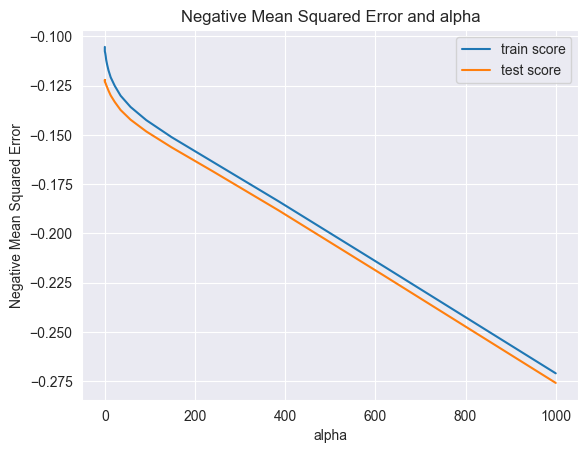

In [792]:
##Plot mean test and train scores with alpha
ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Squared Error')
plt.title("Negative Mean Squared Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [793]:
ridge_model_cv.best_params_

{'alpha': 0.0727895384398315}

In [794]:
best_ridge_alpha = round(ridge_model_cv.best_params_['alpha'], 3)
best_ridge_alpha

0.073

In [795]:
##Checking the coefficient values with lambda (alpha) = 0.07
ridge = Ridge(alpha=best_ridge_alpha)
ridge.fit(X_train, y_train)

print("Intercept: ", ridge.intercept_)
print("Coefficients:\n",ridge.coef_)

Intercept:  -0.384194005562139
Coefficients:
 [ 0.26664951  0.1661216   0.4066525  -0.23973589 -0.13038721  0.27582942
  0.44953341  0.23103236  0.44533875  0.47646938  0.38660215  0.29589038
  0.25464884  0.19646612  1.14543839  0.41128934 -0.49589624  0.23896622
  0.49316283  0.35288828  0.17862614  0.41465825  0.32478303  0.28459217
  0.49232583  0.71409889  0.33496797  0.26775657 -0.27099573  0.70530413
 -0.985488    0.17222704 -0.30740532  0.13794917  0.50380032  0.09802673
  0.35628293 -0.22482014 -0.25078775 -0.16048124 -0.07762107 -0.12536802
 -1.20811561 -0.77413753  0.171677  ]


In [796]:
##Making predictions for train and test sets: Ridge Regression Model
y_pred_train_r = ridge.predict(X_train)
y_pred_test_r = ridge.predict(X_test)

##R2 score for Ridge Regression Model
r2_score_ridge_train = r2_score(y_true= y_train, y_pred= y_pred_train_r)
r2_score_ridge_test = r2_score(y_true= y_test, y_pred= y_pred_test_r)

##Check the mean squared error (MSE) for Ridge Regression Model
MSE_ridge_train = mean_squared_error(y_train, y_pred_train_r)
MSE_ridge_test = mean_squared_error(y_test, y_pred_test_r)

##Mean Absolute error for train and test sets
MAE_ridge_train = mean_absolute_error(y_train, y_pred_train_r)
MAE_ridge_test = mean_absolute_error(y_test, y_pred_test_r)

##Root Mean Squared Error for Train and Test Sets
RMSE_ridge_train = np.sqrt(MSE_ridge_train)
RMSE_ridge_test = np.sqrt(MSE_ridge_test)

ridge_data = [['Train', r2_score_ridge_train, MSE_ridge_train, MAE_ridge_train, RMSE_ridge_train],
        ['Test', r2_score_ridge_test, MSE_ridge_test, MAE_ridge_test, RMSE_ridge_test]]
ridge_results = pd.DataFrame(ridge_data, columns=['ResultType', 'R2 score', 'MSE score', 'MAE score', 'RMSE score'])
ridge_results.set_index('ResultType', inplace=True)
ridge_results

,R2 score,MSE score,MAE score,RMSE score
ResultType,,,,
Train,0.893191,0.106809,0.242429,0.326816
Test,0.864171,0.136379,0.264973,0.369296


In [797]:
##Creating a dataframe of features and coefficients
ridge_coefficients = pd.DataFrame({
    'Features':X_train.columns,
    'Coefficient':ridge.coef_.round(4)
})

ridge_coefficients.head()

,Features,Coefficient
0,OverallQual,0.2666
1,BsmtFinSF1,0.1661
2,GrLivArea,0.4067
3,PropAgeAtSale,-0.2397
4,ExterQual_encoded,-0.1304


### Residual Analysis of Ridge Model

#### Plots for Train data

<Figure size 750x750 with 0 Axes>

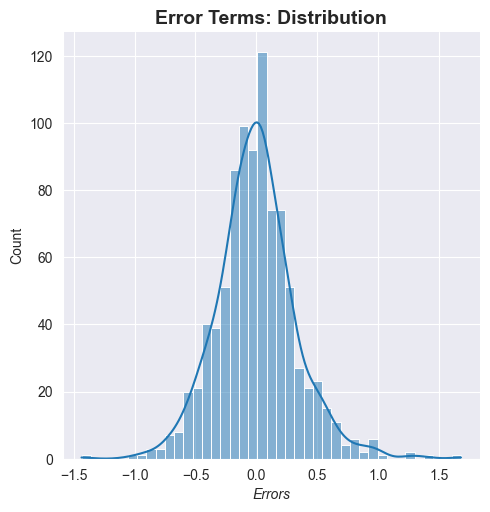

In [798]:
# Residuals of train data
res = y_train - y_pred_train_r

# Plot the histogram of the error terms
plt.figure(figsize=(5,5), dpi=150)
sns.displot(res, kde=True)
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 14)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 10)
plt.show()

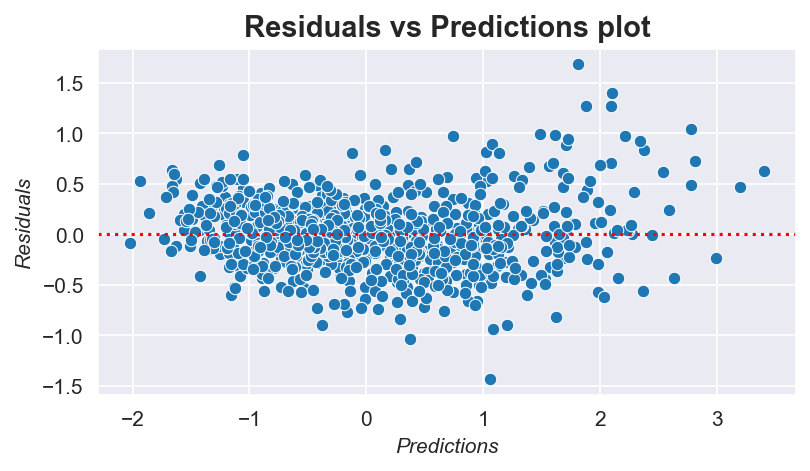

In [799]:
plt.figure(figsize=(6,3), dpi=150)
sns.scatterplot(x=y_pred_train_r, y=res)
plt.title('Residuals vs Predictions plot', fontweight='bold', fontsize = 14)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Residuals', fontstyle='italic', fontsize = 10)
plt.show()

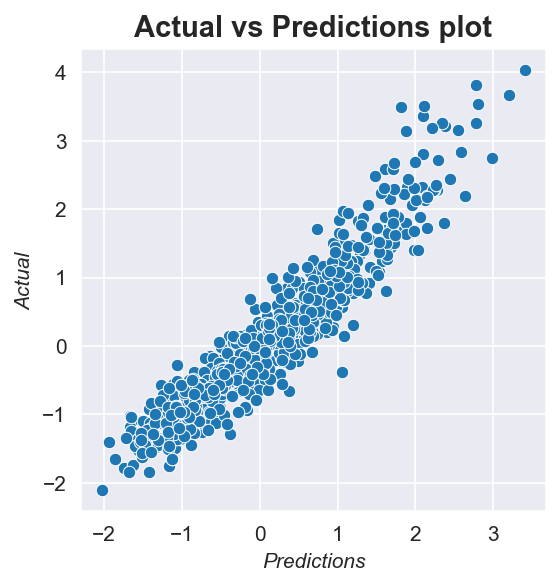

In [800]:
plt.figure(figsize=(4, 4), dpi=150)
sns.scatterplot(x=y_pred_train_r, y=y_train)
plt.title('Actual vs Predictions plot', fontweight='bold', fontsize = 14)
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Actual', fontstyle='italic', fontsize = 10)
plt.show()

#### Plots for Test data

<Figure size 750x750 with 0 Axes>

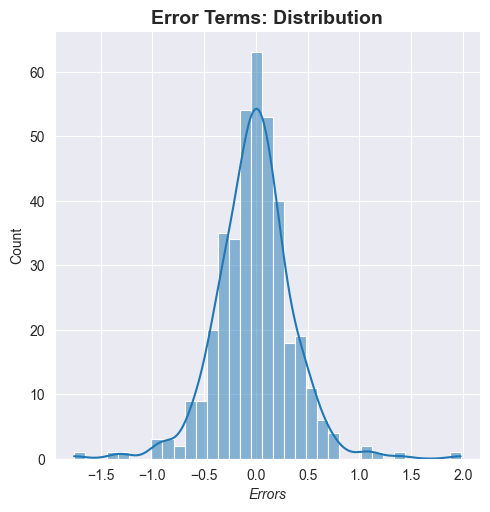

In [801]:
# Residuals of train data
res = y_test - y_pred_test_r

# Plot the histogram of the error terms
plt.figure(figsize=(5,5), dpi=150)
sns.displot(res, kde=True)
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 14)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 10)
plt.show()

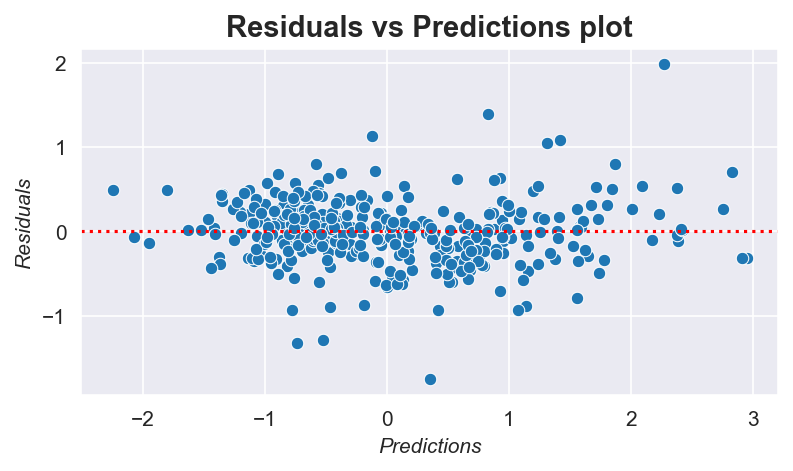

In [802]:
plt.figure(figsize=(6,3), dpi=150)
sns.scatterplot(x=y_pred_test_r, y=res)
plt.title('Residuals vs Predictions plot', fontweight='bold', fontsize = 14)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Residuals', fontstyle='italic', fontsize = 10)
plt.show()

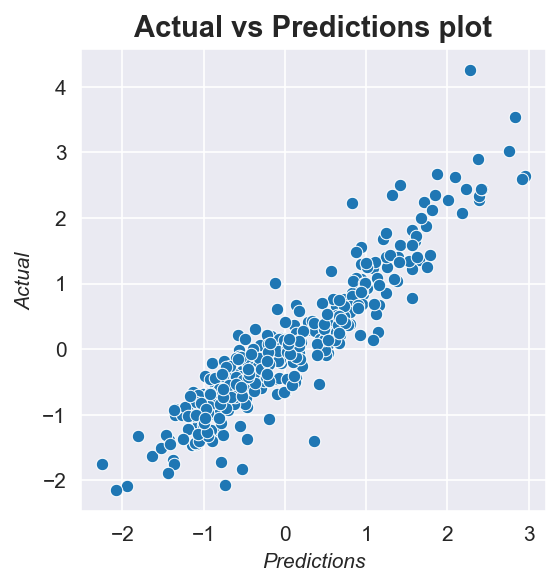

In [803]:
plt.figure(figsize=(4, 4), dpi=150)
sns.scatterplot(x=y_pred_test_r, y=y_test)
plt.title('Actual vs Predictions plot', fontweight='bold', fontsize = 14)
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Actual', fontstyle='italic', fontsize = 10)
plt.show()

## Lasso Regression

In [804]:
params = {'alpha': np.logspace(-3, 3, 30)} ## range is from 0.001 to 1000

lasso = Lasso()

##Cross-Validation
folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params,
                        scoring= 'neg_mean_squared_error', 
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [805]:
##Display the mean scores
lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
0,0.001,-0.113239,-0.125337,1
1,0.00161,-0.116919,-0.127108,2
2,0.002593,-0.121473,-0.130572,3
3,0.004175,-0.127230,-0.135722,4
4,0.006723,-0.134510,-0.141937,5
5,0.010826,-0.142083,-0.149450,6
6,0.017433,-0.150820,-0.156499,7
7,0.028072,-0.156217,-0.160774,8
8,0.045204,-0.165061,-0.169968,9
9,0.07279,-0.176568,-0.181258,10


In [806]:
# Since we got the least alpha, check if alpha can still be reduced
params = {'alpha': np.logspace(-7, -1, 100)} ## range is from 0.0000001 to 0.1

lasso = Lasso()

##Cross-Validation
folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params,
                        scoring= 'neg_mean_squared_error', 
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
lasso_model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-07, 1.14975700e-07, 1.32194115e-07, 1.51991108e-07,
       1.74752840e-07, 2.00923300e-07, 2.31012970e-07, 2.65608778e-07,
       3.05385551e-07, 3.51119173e-07, 4.03701726e-07, 4.64158883e-07,
       5.33669923e-07, 6.13590727e-07, 7.05480231e-07, 8.11130831e-07,
       9.32603347e-07, 1.07226722e-06, 1.23284674e-06, 1....
       7.05480231e-03, 8.11130831e-03, 9.32603347e-03, 1.07226722e-02,
       1.23284674e-02, 1.41747416e-02, 1.62975083e-02, 1.87381742e-02,
       2.15443469e-02, 2.47707636e-02, 2.84803587e-02, 3.27454916e-02,
       3.76493581e-02, 4.32876128e-02, 4.97702356e-02, 5.72236766e-02,
       6.57933225e-02, 7.56463328e-02, 8.69749003e-02, 1.00000000e-01])},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [807]:
##Display the mean scores
lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
20,0.000002,-0.105320,-0.122259,1
19,0.000001,-0.105320,-0.122259,2
21,0.000002,-0.105320,-0.122259,3
18,0.000001,-0.105320,-0.122259,4
17,0.000001,-0.105320,-0.122259,5
...,...,...,...,...
95,0.057224,-0.171870,-0.176323,96
96,0.065793,-0.174320,-0.178898,97
97,0.075646,-0.177551,-0.182288,98
98,0.086975,-0.181822,-0.186760,99


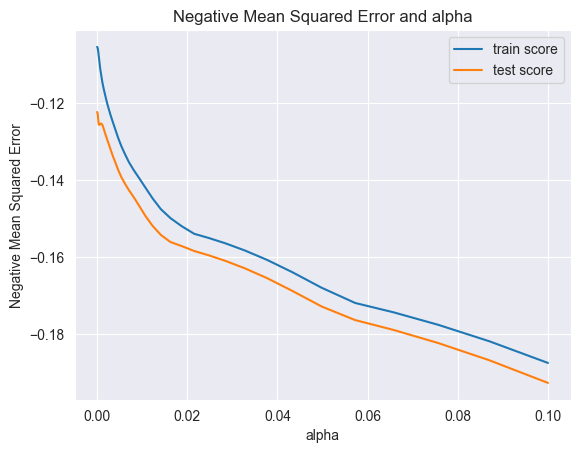

In [808]:
##Plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

##plotting
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Squared Error')

plt.title("Negative Mean Squared Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [809]:
lasso_model_cv.best_params_

{'alpha': 1.6297508346206435e-06}

In [810]:
best_lasso_alpha = round(lasso_model_cv.best_params_['alpha'], 8)
best_lasso_alpha

1.63e-06

In [811]:
# check the coefficient values with lambda = 0.00000163
lasso = Lasso(alpha=best_lasso_alpha)
lasso.fit(X_train, y_train)

print("Intercept: ",lasso.intercept_)
print("Coefficients:\n ",lasso.coef_)

Intercept:  -0.3896487541889745
Coefficients:
  [ 0.26535897  0.16584163  0.40756908 -0.24072079 -0.13116321  0.28291789
  0.46060597  0.22632433  0.45084365  0.48490851  0.3951877   0.30213148
  0.25835723  0.21667548  1.32260664  0.42070405 -0.50340111  0.24369443
  0.52356883  0.37027327  0.17717636  0.41274495  0.3358315   0.28516933
  0.49524107  0.72279144  0.34052499  0.26903366 -0.28345432  0.76593328
 -1.06975834  0.17280709 -0.33217742  0.14166506  0.55231705  0.10050808
  0.36809164 -0.2277929  -0.25999008 -0.16260856 -0.07901135 -0.13341714
 -1.42270813 -0.90035701  0.17158561]


In [812]:
##Making predictions for train and test sets: Lasso Regression Model
y_pred_train_l = lasso.predict(X_train)
y_pred_test_l = lasso.predict(X_test)

##R2 score for Lasso Regression Model
r2_score_lasso_train = r2_score(y_true= y_train, y_pred= y_pred_train_l)
r2_score_lasso_test = r2_score(y_true= y_test, y_pred= y_pred_test_l)

##Check the mean squared error (MSE) for Lasso Regression Model
MSE_lasso_train = mean_squared_error(y_train, y_pred_train_l)
MSE_lasso_test = mean_squared_error(y_test, y_pred_test_l)

##Mean Absolute error for train and test sets
MAE_lasso_train = mean_absolute_error(y_train, y_pred_train_l)
MAE_lasso_test = mean_absolute_error(y_test, y_pred_test_l)

##Root Mean Squared Error for Train and Test Sets
RMSE_lasso_train = np.sqrt(MSE_lasso_train)
RMSE_lasso_test = np.sqrt(MSE_lasso_test)

lasso_data = [['Train', r2_score_lasso_train, MSE_lasso_train, MAE_lasso_train, RMSE_lasso_train],
        ['Test', r2_score_lasso_test, MSE_lasso_test, MAE_lasso_test, RMSE_lasso_test]]
lasso_results = pd.DataFrame(lasso_data, columns=['ResultType', 'R2 score', 'MSE score', 'MAE score', 'RMSE score'])
lasso_results.set_index('ResultType', inplace=True)
lasso_results

,R2 score,MSE score,MAE score,RMSE score
ResultType,,,,
Train,0.893257,0.106743,0.242335,0.326716
Test,0.863074,0.137482,0.265546,0.370785


In [813]:
##Creating a dataframe of features and coefficients
lasso_coefficients = pd.DataFrame({
    'Features':X_train.columns,
    'Coefficient':lasso.coef_.round(4)
})

lasso_coefficients.head()

,Features,Coefficient
0,OverallQual,0.2654
1,BsmtFinSF1,0.1658
2,GrLivArea,0.4076
3,PropAgeAtSale,-0.2407
4,ExterQual_encoded,-0.1312


### Residual Analysis of Lasso Model

#### Plots for Train data

<Figure size 750x750 with 0 Axes>

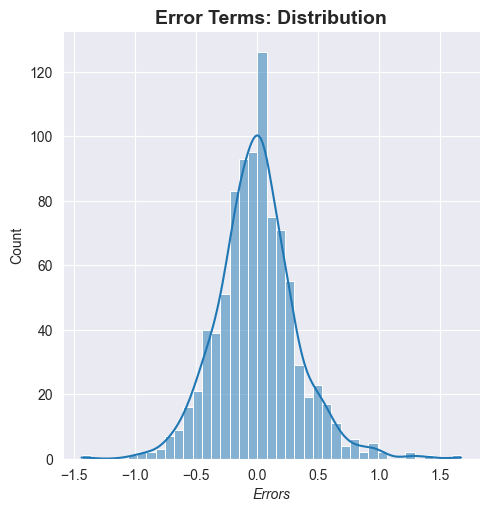

In [814]:
# Residuals of train data
res = y_train - y_pred_train_l

# Plot the histogram of the error terms
plt.figure(figsize=(5,5), dpi=150)
sns.displot(res, kde=True)
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 14)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 10)
plt.show()

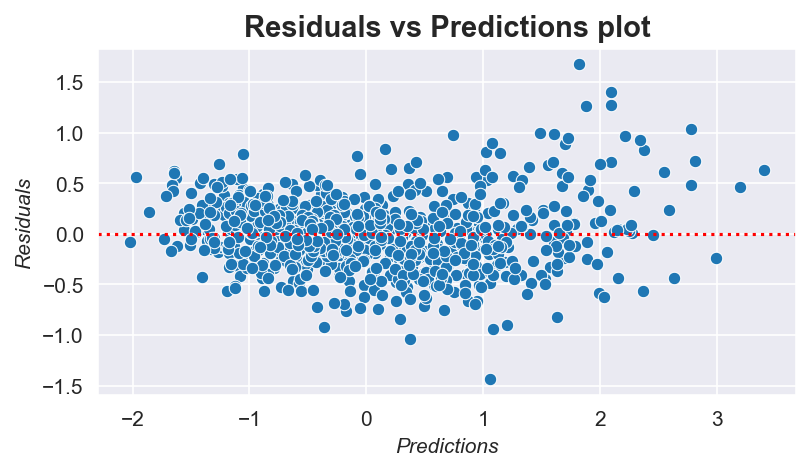

In [815]:
plt.figure(figsize=(6,3), dpi=150)
sns.scatterplot(x=y_pred_train_l, y=res)
plt.title('Residuals vs Predictions plot', fontweight='bold', fontsize = 14)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Residuals', fontstyle='italic', fontsize = 10)
plt.show()

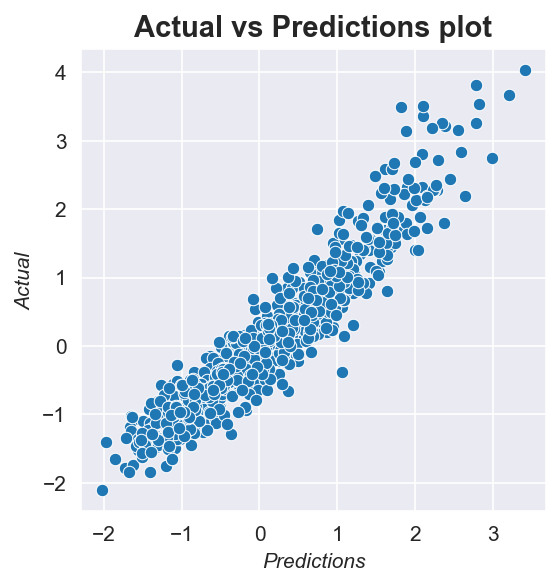

In [816]:
plt.figure(figsize=(4, 4), dpi=150)
sns.scatterplot(x=y_pred_train_l, y=y_train)
plt.title('Actual vs Predictions plot', fontweight='bold', fontsize = 14)
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Actual', fontstyle='italic', fontsize = 10)
plt.show()

#### Plots for Test data

<Figure size 750x750 with 0 Axes>

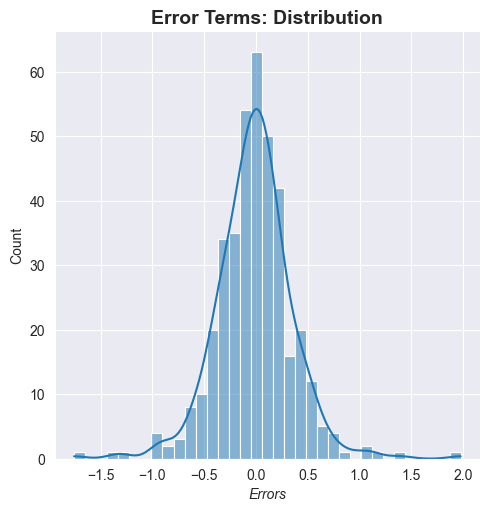

In [817]:
# Residuals of test data
res = y_test - y_pred_test_l

# Plot the histogram of the error terms
plt.figure(figsize=(5,5), dpi=150)
sns.displot(res, kde=True)
plt.title('Error Terms: Distribution', fontweight='bold', fontsize = 14)               
plt.xlabel('Errors', fontstyle='italic', fontsize = 10)
plt.show()

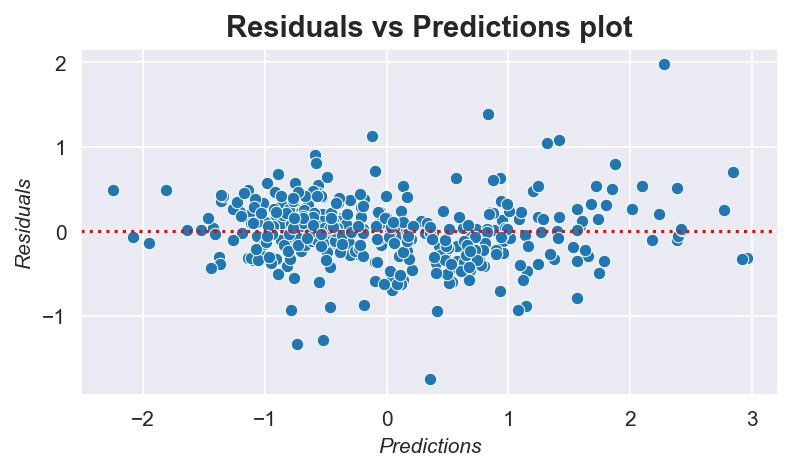

In [818]:
plt.figure(figsize=(6,3), dpi=150)
sns.scatterplot(x=y_pred_test_l, y=res)
plt.title('Residuals vs Predictions plot', fontweight='bold', fontsize = 14)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Residuals', fontstyle='italic', fontsize = 10)
plt.show()

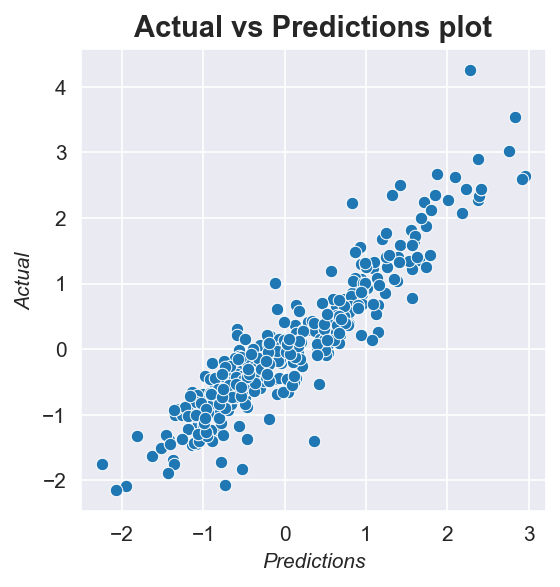

In [819]:
plt.figure(figsize=(4, 4), dpi=150)
sns.scatterplot(x=y_pred_test_l, y=y_test)
plt.title('Actual vs Predictions plot', fontweight='bold', fontsize = 14)
plt.xlabel('Predictions', fontstyle='italic', fontsize = 10)
plt.ylabel('Actual', fontstyle='italic', fontsize = 10)
plt.show()